# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import plotly.graph_objs as go
from tensorflow.keras.models import load_model

# **Data Loading**

In [2]:
df = pd.read_csv("nifty50.csv")
df

,Date,Open,High,Low,Close,Shares Traded,Turnover(in cr)
0,01-Jan-18,10531.70,10537.85,10423.10,10435.55,134532090.0,7546.56
1,02-Jan-18,10477.55,10495.20,10404.65,10442.20,158092430.0,8665.47
2,03-Jan-18,10482.65,10503.60,10429.55,10443.20,172516859.0,9541.60
3,04-Jan-18,10469.40,10513.00,10441.45,10504.80,180257392.0,9561.95
4,05-Jan-18,10534.25,10566.10,10520.10,10558.85,186469717.0,10306.22
...,...,...,...,...,...,...,...
1575,14-May-24,22112.90,22270.05,22081.25,22217.85,230238941.0,23741.66
1576,15-May-24,22255.60,22297.55,22151.75,22200.55,231935478.0,23815.79
1577,16-May-24,22319.20,22432.25,22054.55,22403.85,368945092.0,38836.11
1578,17-May-24,22415.25,22502.15,22345.65,22466.10,242654570.0,27388.67


In [3]:
print(df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Shares Traded',
       'Turnover(in cr)'],
      dtype='object')


# **Data Preprocessing**

In [4]:
# Parse the Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Set the Date column as the index
df.set_index('Date', inplace=True)

# Sort the data by date
df.sort_index(inplace=True)

# Selecting the feature and target columns
data = df[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# **Train-Test Split**

In [5]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# **LSTM Model**

In [6]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# **Training the model**

In [7]:
# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=100)

Epoch 1/100
19/19 [==============================] - 6s 98ms/step - loss: 0.0353
Epoch 2/100
19/19 [==============================] - 2s 91ms/step - loss: 0.0037
Epoch 3/100
19/19 [==============================] - 2s 86ms/step - loss: 0.0010
Epoch 4/100
19/19 [==============================] - 1s 69ms/step - loss: 6.7564e-04
Epoch 5/100
19/19 [==============================] - 1s 79ms/step - loss: 6.3237e-04
Epoch 6/100
19/19 [==============================] - 1s 79ms/step - loss: 6.3062e-04
Epoch 7/100
19/19 [==============================] - 2s 96ms/step - loss: 6.3716e-04
Epoch 8/100
19/19 [==============================] - 2s 94ms/step - loss: 6.1797e-04
Epoch 9/100
19/19 [==============================] - 2s 82ms/step - loss: 5.8060e-04
Epoch 10/100
19/19 [==============================] - 1s 70ms/step - loss: 5.6343e-04
Epoch 11/100
19/19 [==============================] - 1s 77ms/step - loss: 5.5805e-04
Epoch 12/100
19/19 [==============================] - 1s 73ms/step - loss: 

# **Evaluating The Model**

In [8]:
# Predicting on the test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Inverse transform the y_test to compare with the predictions
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the mean squared error
mse = np.mean((predictions - y_test)**2)
print(f'Mean Squared Error: {mse}')

8/8 [==============================] - 3s 18ms/step
Mean Squared Error: 34383.39571810134


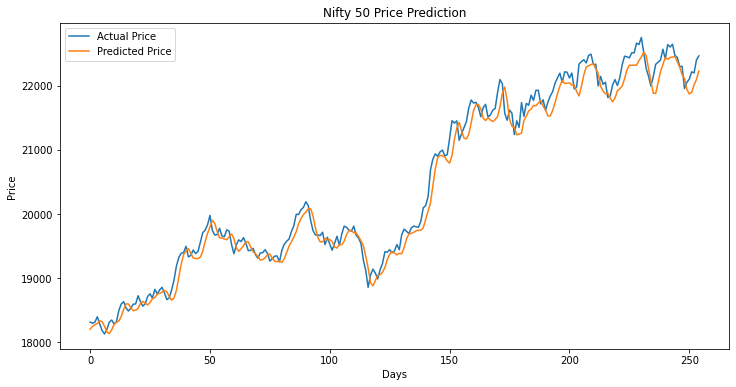

In [9]:
# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Nifty 50 Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Predicting the next 5 days**

In [10]:
next_5_days_predictions = []
last_sequence = X_test[-1:, :, :]
for _ in range(5):
    prediction = model.predict(last_sequence)
    next_5_days_predictions.append(scaler.inverse_transform(prediction))
    # Remove the first element from last_sequence and add the prediction at its last position
    last_sequence = np.concatenate([last_sequence[:, 1:, :], prediction.reshape(1, 1, 1)], axis=1)

print(next_5_days_predictions)

1/1 [==============================] - 0s 52ms/step
[array([[22231.201]], dtype=float32), array([[22224.53]], dtype=float32), array([[22160.328]], dtype=float32), array([[22064.186]], dtype=float32), array([[21950.416]], dtype=float32)]


In [11]:
# Define a list of colors
colors = ['red', 'green', 'blue', 'orange', 'purple']

# Plotting actual and predicted prices
actual_trace = go.Scatter(x=df.index[-len(y_test):], y=y_test.flatten(), mode='lines', name='Actual Price', line=dict(color='blue'))
predicted_trace = go.Scatter(x=df.index[-len(predictions):], y=predictions.flatten(), mode='lines', name='Predicted Price', line=dict(color='orange'))

# Calculate the next 5 dates after the last date in the dataset
last_date = df.index[-1]
next_5_days_index = pd.date_range(last_date + pd.Timedelta(days=1), periods=5)

# Plotting prices for the next 5 days
next_5_days_trace = []
predict_price = predictions[-1][0]
for i, price in enumerate(next_5_days_predictions, start=1):
    next_day_trace = go.Scatter(x=[last_date, next_5_days_index[i-1]], y=[predict_price, price[0][0]], mode='lines', name=f'Next Day {i}', line=dict(color=colors[i-1]))
    next_5_days_trace.append(next_day_trace)
    last_date = next_5_days_index[i-1]
    predict_price = price[0][0]

# print(next_5_days_trace)
# Combine all traces
traces = [actual_trace, predicted_trace]+next_5_days_trace
# Define layout
layout = go.Layout(title='Actual vs. Predicted Prices with Next 5 Days Predictions',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Price'),
                   legend=dict(orientation='h'),
                   showlegend=True)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show interactive plot
fig.show()


In [14]:
model_path = r"C:\Users\aichr\OneDrive\Desktop\ALL FOLDERS HERE\Finance_DL_Project\model"
model.save(model_path)

INFO:tensorflow:Assets written to: C:\Users\aichr\OneDrive\Desktop\ALL FOLDERS HERE\Finance_DL_Project\model\assets


INFO:tensorflow:Assets written to: C:\Users\aichr\OneDrive\Desktop\ALL FOLDERS HERE\Finance_DL_Project\model\assets


In [105]:
loaded_model = load_model(model_path)

In [110]:
import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Function to load the data
# @st.cache(hash_funcs={pd.DataFrame: lambda _: None})
def load_data():
    df = pd.read_csv("nifty50.csv")
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    return df

# Function to create time series dataset
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Function to predict next 5 days
def predict_next_5_days(model, last_sequence, scaler):
    next_5_days_predictions = []
    for _ in range(5):
        prediction = model.predict(last_sequence)
        next_5_days_predictions.append(scaler.inverse_transform(prediction))
        last_sequence = np.concatenate([last_sequence[:, 1:, :], prediction.reshape(1, 1, 1)], axis=1)
    return next_5_days_predictions

# Main function to run the Streamlit app
def main():
    # Set title
    st.title("Stock Price Prediction App")

    # Load the data
    df = load_data()

    # Load the pre-trained model
    model = load_model(model_path)

    # Selecting the feature and target columns
    data = df[['Close']].values

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Split data into train and test sets
    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    # Create time series data
    time_step = 60
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Reshape input to be [samples, time steps, features] required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Predicting on the test data
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    # Get the last sequence for predicting next 5 days
    last_sequence = X_test[-1:, :, :]

    # Predict next 5 days
    next_5_days_predictions = predict_next_5_days(model, last_sequence, scaler)

    # Plotting using Plotly
    actual_trace = go.Scatter(x=df.index[-len(y_test):], y=y_test.flatten(), mode='lines', name='Actual Price', line=dict(color='blue'))
    predicted_trace = go.Scatter(x=df.index[-len(predictions):], y=predictions.flatten(), mode='lines', name='Predicted Price', line=dict(color='orange'))

    last_date = df.index[-1]
    next_5_days_index = pd.date_range(last_date + pd.Timedelta(days=1), periods=5)

    next_5_days_trace = []
    predict_price = predictions[-1][0]
    for i, price in enumerate(next_5_days_predictions, start=1):
        next_day_trace = go.Scatter(x=[last_date, next_5_days_index[i-1]], y=[predict_price, price[0][0]], mode='lines', name=f'Next Day {i}', line=dict(color='green'))
        next_5_days_trace.append(next_day_trace)
        last_date = next_5_days_index[i-1]
        predict_price = price[0][0]

    traces = [actual_trace, predicted_trace] + next_5_days_trace
    layout = go.Layout(title='Actual vs. Predicted Prices with Next 5 Days Predictions',
                       xaxis=dict(title='Date'),
                       yaxis=dict(title='Price'),
                       legend=dict(orientation='h'),
                       showlegend=True)

    fig = go.Figure(data=traces, layout=layout)

    # Display the plot
    st.plotly_chart(fig)

if __name__ == "__main__":
    main()


1/1 [==============================] - 0s 27ms/step
